# 06. Pre-training

The grand finale of all the ideas and concepts discussed thus far is pre-training a modern LLM on a pre-training dataset. We use the `r50k` tokenizer, use the advanced LLM we developed earlier and train it on the FineWeb-EDU dataset from HuggingFace. We use the learning rates we got from our scaling laws and pre-train the model. 

However, training an LLM is not as straightforward when you want to increase the number of parameters and use multiple GPUs. 

Let's start with creating a 1.5B parameter MoE model.
I also very highly recommend running this notebook on a multi-GPU node, for instance 8xH200. Again, you can use Lightning AI studio for this.

In [4]:
import torch
import tiktoken
from src.shraygpt import ShrayGPT
torch.set_num_threads(1) # Prevents deadlocks with DataLoader and multiple workers

tokenizer = tiktoken.get_encoding("r50k_base")

def get_total_param_count(module):
    return sum(p.numel() for p in module.parameters())

d_model = 32*32
n_head = 32
d_head = 32
n_layers = 24
num_experts = 6
num_experts_per_tok = 2
block_size = 8192
batch_size = 2

model = ShrayGPT(
    vocab_size=tokenizer.n_vocab, 
    block_size=block_size, 
    d_model=d_model,
    n_head=n_head, 
    d_head=d_head, 
    n_layers=n_layers, 
    num_experts=num_experts, 
    num_experts_per_tok=num_experts_per_tok
)
# model = ShrayGPT.load_from_checkpoint("checkpoints/last-v2.ckpt")
model.hparams.learning_rate_adamw = 3e-4
model.hparams.learning_rate_muon = 1.5e-3
model.hparams.aux_loss_weight = 1e-2
# model.compile(backend="inductor", dynamic=True, mode="reduce-overhead")

params = get_total_param_count(model)
print(f"Total parameters: {params/1e9:.2f}B")

Total parameters: 1.58B


Now let's create a dataset and training and validation data loaders using the HuggingFace's Fineweb-EDU dataset.

In [5]:
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
import torch.distributed as dist

class IterableTextDataset(IterableDataset):
    def __init__(self, tokenizer, hf_dataset, block_size):
        self.tokenizer = tokenizer
        self.hf_dataset = hf_dataset
        self.block_size = block_size

    def _rank_world(self):
        if dist.is_available() and dist.is_initialized():
            return dist.get_rank(), dist.get_world_size()
        return 0, 1

    def __iter__(self):
        rank, world = self._rank_world()

        # Shard the HF streaming dataset so each rank reads a disjoint slice
        ds = self.hf_dataset
        if hasattr(ds, "shard"):
            ds = ds.shard(num_shards=world, index=rank, contiguous=True)

        buffer = []
        for item in ds:
            if 'text' in item:
                tokenized = self.tokenizer.encode(item['text']) + [self.tokenizer.eot_token]
                buffer.extend(tokenized)
                while len(buffer) >= self.block_size + 1:
                    x = torch.tensor(buffer[:self.block_size], dtype=torch.long)
                    y = torch.tensor(buffer[1:self.block_size+1], dtype=torch.long)
                    yield x, y
                    buffer = buffer[self.block_size:]


full_train_stream = load_dataset('HuggingFaceFW/fineweb-edu', name='sample-350BT', split='train', streaming=True)
num_val_samples = 10000  # Let's reserve 10,000 samples for validation.

val_stream_full = full_train_stream.take(num_val_samples)
train_stream_full = full_train_stream.skip(num_val_samples)

train_dataset_full = IterableTextDataset(tokenizer, train_stream_full, block_size)
val_dataset_full = IterableTextDataset(tokenizer, val_stream_full, block_size)

train_loader = DataLoader(
    train_dataset_full, 
    batch_size=batch_size, 
    num_workers=2,
    prefetch_factor=2,  
    pin_memory=True # Helps speed up data transfer to the GPU
)
val_loader = DataLoader(
    val_dataset_full, 
    batch_size=batch_size, 
    num_workers=2,
    prefetch_factor=2,  
    pin_memory=True
)

Resolving data files:   0%|          | 0/2410 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/472 [00:00<?, ?it/s]

We now add code to evaluate our LLM on the Hellaswag dataset. HellaSwag is a multiple-choice benchmark designed to probe a language model's commonsense reasoning and narrative completion skills. Each example pairs a natural-language context (usually an incomplete story or instructional description) with four candidate endings that are grammatically plausible. The dataset was intentionally constructed to make superficial cues ineffective, so robust performance requires understanding real-world dynamics and linguistic nuance.

Key characteristics include:
- **Challenging distractors:** The incorrect endings are adversarially generated, so they are fluent and contextually plausible.
- **Narrative and procedural diversity:** Prompts draw from activity descriptions, WikiHow instructions, and grounded video captions, encouraging broad coverage of everyday situations.
- **Focus on generative scoring:** Although evaluation is cast as multiple choice, models must internally score free-form completions to select the most coherent ending.

We load the HellaSwag validation split and a matching accuracy metric from the Hugging Face `datasets` and `evaluate` libraries, optionally subsampling for quicker experiments. Each validation example supplies a context and four candidate endings. For every ending, we concatenate it with the context, tokenize the result, and run it through the model in evaluation mode to obtain the autoregressive loss. The ending with the lowest loss becomes the model's prediction, which we compare against the gold label to accumulate accuracy. This routine aligns the evaluation with our training objective—better language modeling likelihood should translate directly into higher HellaSwag accuracy.

During longer training runs we call this evaluation hook periodically, logging the resulting accuracy so it can be tracked alongside training metrics. In this way, HellaSwag serves as an end-to-end proxy for the model's ability to apply learned knowledge to structured reasoning tasks.

In [3]:
import torch
import evaluate
from datasets import load_dataset
from tqdm import tqdm

print("Loading HellaSwag validation set and accuracy metric...")
hellaswag_val = load_dataset("hellaswag", split="validation")
accuracy_metric = evaluate.load("accuracy")

# For a quick demonstration, let's use a small subset of the validation set.
# A full evaluation would run on the entire set.
subset_size = 2000
hellaswag_subset = hellaswag_val.select(range(subset_size))

# 2. Create an evaluation function
def evaluate_on_hellaswag(model, tokenizer, dataset):
    """
    Evaluates a model on the HellaSwag dataset.
    """
    model.eval()
    
    predictions = []
    references = []
    
    # The core idea is to calculate the loss for the context concatenated with each ending.
    # The ending that results in the lowest loss is the model's prediction.
    
    for example in tqdm(dataset, desc="Evaluating HellaSwag"):
        context = example['ctx']
        endings = example['endings']
        correct_label = int(example['label'])
        
        context_tokens = tokenizer.encode(context)
        
        losses = []
        with torch.no_grad():
            for ending in endings:
                # Create the full input by combining context and the current ending
                full_text_tokens = context_tokens + tokenizer.encode(ending)
                
                # Prepare input and target tensors
                x = torch.tensor([full_text_tokens[:-1]], dtype=torch.long, device=model.device)
                y = torch.tensor([full_text_tokens[1:]], dtype=torch.long, device=model.device)
                
                # Get the loss for this specific continuation
                logits, _, aux_loss_ = model(x)
                total_loss, main_loss, aux_loss = model._calculate_loss(logits, y.to(model.device), aux_loss_)
                losses.append(main_loss.item())
        
        # The prediction is the index of the ending with the minimum loss
        prediction = torch.argmin(torch.tensor(losses)).item()
        
        predictions.append(prediction)
        references.append(correct_label)
        
    # 3. Compute the final score
    print("Computing final accuracy...")
    results = accuracy_metric.compute(predictions=predictions, references=references)
    return results

# hellaswag_results = evaluate_on_hellaswag(model, tokenizer, hellaswag_subset)
# hellaswag_results

Loading HellaSwag validation set and accuracy metric...


We now introduce the concepts of mult-GPU and mixed-precision training. 

Training large language models efficiently requires spreading computation across multiple devices while maintaining numerical stability. This guide summarizes the major forms of GPU parallelism, how PyTorch Lightning orchestrates multi-GPU training, and why mixed precision is a default optimization in this project.
Different parallelism strategies partition work across accelerators in complementary ways. Modern systems often compose multiple techniques.

### Data parallelism
- **Concept:** Replicate the full model on each GPU, split every batch of data, and aggregate gradients after each backward pass.
- **When to use:** Fits when the model parameters comfortably fit into individual GPU memory and input batches are large.
- **Trade-offs:** Communication cost for synchronizing gradients grows with parameter count, but scaling is straightforward and stateless.

PyTorch's `DistributedDataParallel` (DDP) is the de facto data-parallel implementation. Each process hosts a model replica and maintains local optimizer state while `all_reduce` operations keep gradients synchronized.

### Model parallelism
When the model itself is too large for a single device, we split its parameters.

- **Tensor (intra-layer) parallelism:** Each layer's tensors are sharded across GPUs. Collective operations (e.g., `all_gather`, `reduce_scatter`) coordinate matrix multiplications. Tensor parallelism reduces per-GPU activation and weight memory but introduces more frequent communication.
- **Pipeline parallelism:** Consecutive layers are assigned to stages on different devices. Micro-batches move through the pipeline in staggered fashion to keep stages busy. While communication is limited to stage boundaries, pipeline bubbles can reduce utilization if micro-batch counts are small.
- **Sequence/context parallelism:** Long contexts are split across devices, sharing attention key/value memory. This is useful for inference or training with very long sequences.

Model-parallel strategies are often combined with data parallelism ("3D" parallelism) to balance memory constraints and throughput.

### Parameter and optimizer sharding
Techniques like ZeRO (Zero Redundancy Optimizer) partition optimizer states, gradients, and sometimes parameters across data-parallel ranks. This reduces memory duplication while keeping a data-parallel programming model.

## Multi-GPU training in PyTorch Lightning

PyTorch Lightning abstracts the distributed setup via **strategies** that configure process launch, distributed collectives, and accelerator plugins. Key capabilities for multi-GPU runs include:

- **DDP strategy:** Wraps PyTorch DDP, automatically launching one process per GPU (`Trainer(strategy="ddp")`). Lightning handles dataset sharding via `DistributedSampler`, synchronizes batch norms, and coordinates gradient reduction.
- **Fully Sharded Data Parallel (FSDP):** Activates parameter sharding to reduce memory footprints (`strategy="fsdp"` with optional auto-wrap policies).
- **DeepSpeed integration:** Enables ZeRO stages, gradient accumulation, and activation checkpointing via `strategy="deepspeed"`.
- **Accelerator plugins:** `Trainer(accelerator="gpu", devices=n)` selects available GPUs, while Lightning manages device placement and precision configuration.

Because Lightning centralizes the launch configuration, scripts stay close to single-GPU code. Callbacks and loggers remain device-agnostic, and synchronization barriers (e.g., `rank_zero_only`) ensure safe logging.

## Mixed precision training

### Why mixed precision helps
- **Higher throughput:** FP16 or bfloat16 math uses tensor cores, dramatically increasing matrix multiply throughput on modern GPUs.
- **Lower memory usage:** Half-precision activations and gradients halve memory consumption, enabling larger batches or models.
- **Similar convergence:** With loss scaling to avoid underflow, models typically match FP32 accuracy while converging faster.

### Mixed precision in PyTorch Lightning
Lightning toggles precision via the `precision` flag, e.g., `Trainer(precision="16-mixed")` for automatic mixed precision (AMP) or `precision="bf16-mixed"` on hardware with bfloat16 support. Under the hood Lightning wraps forward passes in `torch.autocast`, applies dynamic loss scaling when using FP16, and ensures optimizer steps run in FP32 to preserve stability. Precision settings integrate with all distributed strategies, so mixed precision works seamlessly across multi-GPU runs.

### When to fall back to full precision
If gradients become unstable (e.g., persistent `NaN`s) or certain custom CUDA kernels lack half-precision support, switch to `precision=32` or selectively disable AMP for problematic modules. Lightning's strategy abstraction keeps the rest of the training loop unchanged, simplifying experimentation.

By combining distributed strategies with mixed precision, we maximize throughput and keep experiments tractable even when scaling to many GPUs.

I highly recommend watching the [Stanford CS336 Parallelism Lecture](https://www.youtube.com/watch?v=l1RJcDjzK8M&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=7). 


In [ ]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
torch._dynamo.config.capture_scalar_outputs = True
torch.set_float32_matmul_precision('medium')
from huggingface_hub import login
from dotenv import load_dotenv
load_dotenv()

login(token=os.getenv("HF_API_TOKEN")) 

class GenerateTextCallback(L.Callback):
    """A PyTorch Lightning callback to generate text samples at the end of each validation epoch."""
    def __init__(self, prompts, tokenizer, every_n_steps=100):
        super().__init__()
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.every_n_steps = every_n_steps

    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.global_step == 0 or trainer.global_step % self.every_n_steps != 0:
            return
        if not trainer.is_global_zero:
            return  # only rank 0 prints/logs text
        pl_module.print(f"\n\n--- Generating text at step {trainer.global_step} ---")
        tb = getattr(trainer.logger, "experiment", None)
        
        for i, prompt in enumerate(self.prompts):
            start_tokens = self.tokenizer.encode(prompt)
            context = torch.tensor(start_tokens, dtype=torch.long, device=pl_module.device).unsqueeze(0)
            generated_tokens = pl_module.generate_nocache(context, max_new_tokens=100, temperature=0.7, top_k=20)
            generated_text = self.tokenizer.decode(generated_tokens[0].tolist())
            pl_module.print(f"PROMPT: '{prompt}'")
            pl_module.print(f"GENERATED: {generated_text}\n")
            if tb is not None and hasattr(tb, "add_text"):
                tb.add_text(f"samples/prompt_{i}", f"**Prompt:** {prompt}\n\n**Generated:** {generated_text}",
                            global_step=trainer.global_step)

class EvaluateHellaSwag(L.Callback):
    """A PyTorch Lightning callback to evaluate the LLM."""
    def __init__(self, every_n_steps=1000):
        super().__init__()
        self.every_n_steps = every_n_steps

    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.global_step == 0 or trainer.global_step % self.every_n_steps != 0:
            return
        # do heavy eval only on rank 0
        if not trainer.is_global_zero:
            return
        pl_module.print(f"\n\n--- Evaluating at step {trainer.global_step} ---")
        
        hellaswag_results = evaluate_on_hellaswag(pl_module, tokenizer, hellaswag_subset)
        acc = hellaswag_results['accuracy']
        pl_module.print(f"\n\n--- Accuracy: {acc} at step {trainer.global_step} ---")
        pl_module.log("hellaswag/accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=False)


callback = GenerateTextCallback(prompts=["The verdict was", "In a shocking turn of events", "The jury decided to"], 
    tokenizer=tokenizer, every_n_steps=1000)
evalcallback = EvaluateHellaSwag(every_n_steps=1000)
checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="shraygpt-{epoch:02d}-{step:05d}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    save_last=True,
)
lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = L.Trainer(max_steps=200_000, accelerator='auto', devices=8, precision='bf16-mixed', strategy='auto', 
                    num_sanity_val_steps=0, limit_train_batches=1000, limit_val_batches=100,
                    callbacks=[callback, L.pytorch.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=200), evalcallback, checkpoint_cb, lr_monitor],
                    logger=L.pytorch.loggers.TensorBoardLogger("logs/"), log_every_n_steps=1) 

model.automatic_optimization = False
trainer.fit(model, train_loader, val_loader)

The training loss giving us a base model is shown below. 

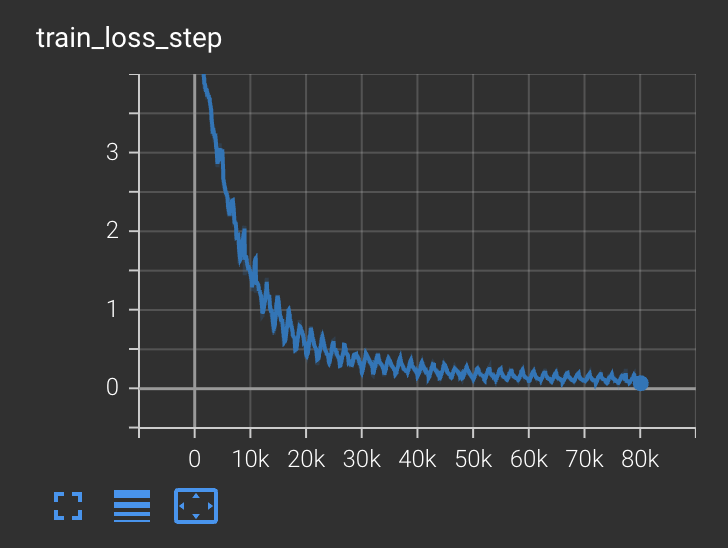

Let's verify with some generations.

In [17]:
import torch
import tiktoken
from src.shraygpt import ShrayGPT
torch.set_num_threads(1) # Prevents deadlocks with DataLoader and multiple workers

tokenizer = tiktoken.get_encoding("r50k_base")

# model = ShrayGPT.load_from_checkpoint("checkpoints/shraygpt-base.ckpt")

model.eval()
prompts = ["Common medical symptoms of viral are", "An interesting political fact is", "The future of AI is"]

for prompt in prompts:
    start_tokens = tokenizer.encode(prompt)
    context = torch.tensor(start_tokens, dtype=torch.long, device=model.device).unsqueeze(0)
    generated_tokens = model.generate_nocache(context, max_new_tokens=100, temperature=0.6, top_k=20)
    generated_text = tokenizer.decode(generated_tokens[0].tolist())
    print(f"PROMPT: '{prompt}'")
    print(f"GENERATED: {generated_text}\n")

PROMPT: 'Common medical symptoms of viral are'
GENERATED: Common medical symptoms of viral are associated with intelina. Patients with MMR are likely to experience epileptococcal acute pancreatitis, and for people carrying juvenile enterocolaria, the infection may be severe. Although, not everybody responds to treatment, the disease can become both life-threatening and can progress to liver failure and death.
What Is Surgery?
Surgery is the only way to heal if it is better for you or your child. Surgery is most often used for the typical purpose of surgery (to prevent pneumonia

PROMPT: 'An interesting political fact is'
GENERATED: An interesting political fact is that slavery was abolished so completely in the 19th century. So, it would have been possible for one hundred years to reach this conclusion.
Hundreds of people believed that slavery was a global problem, but some wonder if the very idea of black slavery still exists. And there is a direct evidence that black people around th

Interesting, but not that great for question answering like a typical chatbot. We shall fix this by supervised fine-tuning in the next section where we continue training the model on datasets focused for chatbot style Q&A.